In [1]:
from transduction.smc.smc import SMC, Particle, logsumexp
from transduction.smc.aa import create_dna_translator, get_source_lm_probs, score_sequence
from transduction.lazy_recursive import LazyRecursive
from transduction import Precover

In [2]:
def score(seq, fst, max_length=100000):
    pc = Precover(fst, seq)
    q, r = pc.decomposition
    contributions = []
    for seq in q.language(max_length=max_length):
        contributions.append(score_sequence(seq, log_space=True) )
        
    total_log_prob = logsumexp(contributions)
    return total_log_prob

def logp_next(seq, fst, vocabulary):
    unnormalized_log_probs = {}
    
    for token in vocabulary:
        next_seq = seq + token
        unnormalized_log_probs[token] = score(next_seq, fst)
    
    log_probs_list = list(unnormalized_log_probs.values())
    log_Z = logsumexp(log_probs_list)
    normalized_dist = {}
    
    for token, log_prob in unnormalized_log_probs.items():
        if log_prob == float('-inf'):
            normalized_dist[token] = float('-inf')
        else:
            normalized_dist[token] = log_prob - log_Z
            
    return normalized_dist

In [3]:
seq = "QMQMQ"
fst = create_dna_translator()
smc = SMC(fst, LazyRecursive, seq, get_source_lm_probs, num_particles=100)

In [4]:
p = Particle.initial(fst.I, fst, seq)
p

π(x=, #states=1, w=0.00, Active)

In [5]:
smc.get_valid_proposal_tokens(p)

['C', 'C']

In [6]:
particles = smc()
particles

[π(x=CAAATGCAGATGCAG, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAAATGCAA, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAGATGCAA, #states=1, w=-20.82, Univ),
 π(x=CAAATGCAAATGCAG, #states=1, w=-21.63, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAAATGCAA, #states=1, w=-21.22, Univ),
 π(x=CAAATGCAGATGCAG, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAAATGCAAATGCAG, #states=1, w=-21.63, Univ),
 π(x=CAGATGCAAATGCAG, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAAATGCAG, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAGATGCAA, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAAATGCAG, #states=1, w=-21.22, Univ),
 π(x=CAAATGCAAATGCAA, #states=1, w=-21.63, Univ),
 π(x=CAGATGCAGATGCAA, #states=1, w=-20.82, Univ),
 π(x=CAAATGCAAATGCAG, #states=1, w=-21.63, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAAATGCAGATGCAA, #states=1, w=-21.22, Univ),


In [7]:
smc.get_probs()

-21.089179757667765

In [8]:
score(seq, fst)

-21.102405519887025

In [9]:
dist = SMC.get_dist(fst, LazyRecursive, seq, get_source_lm_probs, 100)
dist

{'': -0.7084927426013081,
 'N': -4.364533866701052,
 '*': -3.9678773278446826,
 'A': -3.2389317112097444,
 'T': -3.673134429085266,
 'D': -4.078891124890497,
 'S': -3.1244065209023546,
 'F': -3.550271992810316,
 'R': -3.4231814714026854,
 'E': -4.051704984586337,
 'H': -5.066450469142509,
 'P': -2.9371847092905625,
 'L': -2.580956792627937,
 'G': -3.6991252600899145,
 'M': -4.830401706227683,
 'W': -5.390203005711733,
 'C': -4.433194180818788,
 'K': -4.369201319748548,
 'I': -3.46037698869376,
 'V': -3.694944901658154,
 'Q': -5.058263288907725,
 'Y': -4.398274859631954}

In [11]:
logp_next(seq, fst, fst.B)

{'': -0.6931471805599472,
 'N': -4.3428059215206005,
 '*': -3.9528449999484003,
 'A': -3.324236340526028,
 'T': -3.649658740960657,
 'D': -4.017383521085971,
 'S': -3.1349943408874985,
 'F': -3.54737989184024,
 'R': -3.426515189646448,
 'E': -4.017383521085971,
 'H': -5.035953102080548,
 'P': -2.9565115604007133,
 'L': -2.6422624605642078,
 'G': -3.7297014486341915,
 'M': -4.853631545286593,
 'W': -5.339139361068291,
 'C': -4.422848629194135,
 'K': -4.3428059215206005,
 'I': -3.467337184166702,
 'V': -3.7297014486341915,
 'Q': -5.035953102080548,
 'Y': -4.422848629194135}

# Benchmarking

In [18]:
import math

def kl(p, q):
    kl = 0.0
    for k, log_p in p.items():
        log_q = q.get(k, float('-inf'))

        if log_q == float('-inf'):
            if log_p > float('-inf'):
                return float('inf')
            else:
                continue

        p_k = math.exp(log_p)
        kl += p_k * (log_p - log_q)  

    return kl


In [24]:
import time

seq = "CYIQNCQPLGCYIQ"
start = time.time()
dist_base = logp_next(seq, fst, fst.B)
end = time.time()
print("baseline", end - start)

baseline 83.5999402999878


In [ ]:
stats = dict()


In [30]:
for N in range(1, 100, 10):
    smc = SMC(fst, LazyRecursive, seq, get_source_lm_probs, num_particles=N)
    start = time.time()
    dist = SMC.get_dist(fst, LazyRecursive, seq, get_source_lm_probs, N)
    end = time.time()
    div = kl(dist, dist_base)
    print(f"smc {N}: {end - start} -- {div}")
    stats[N] = (end-start, div, dist)

smc 1: 0.3912627696990967 -- 0.7612480998910456
smc 11: 3.903873920440674 -- 0.054841583466704806
smc 21: 7.281203985214233 -- 0.013449477090910971
smc 31: 10.640288352966309 -- 0.012411286944152795
smc 41: 13.913768291473389 -- 0.0037641583346827846
smc 51: 17.272795915603638 -- 0.008011409373293175
smc 61: 20.508236408233643 -- 0.0077959377489286025
smc 71: 23.837836503982544 -- 0.015448243350357788
smc 81: 28.675513744354248 -- 0.00481077617626219
smc 91: 39.6465482711792 -- 0.0033085209007681572


In [ ]:
for N in [100, 200]:
    smc = SMC(fst, LazyRecursive, seq, get_source_lm_probs, num_particles=N)
    start = time.time()
    dist = SMC.get_dist(fst, LazyRecursive, seq, get_source_lm_probs, N)
    end = time.time()
    div = kl(dist, dist_base)
    print(f"smc {N}: {end - start} -- {div}")
    stats[N] = (end-start, div, dist)

smc 100: 33.112226724624634 -- 0.0035555783511158796
smc 200: 72.72695636749268 -- 0.0018846146014574725


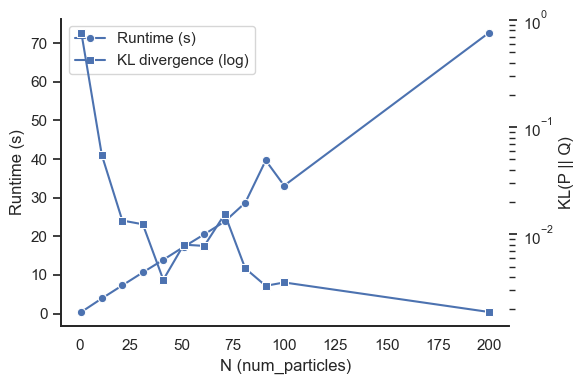

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rows = []
for N, (runtime, kl_div, dist) in stats.items():
    rows.append({"N": N, "runtime": runtime, "kl_div": kl_div})

df = pd.DataFrame(rows).sort_values("N")

plt.rcParams.update({
    "font.family": "Times New Roman",
    "axes.unicode_minus": False,
})

sns.set_theme(style="white")

fig, ax1 = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df,
    x="N",
    y="runtime",
    marker="o",
    ax=ax1,
    legend=False,
)
ax1.set_xlabel("N (num_particles)")
ax1.set_ylabel("Runtime (s)")

ax2 = ax1.twinx()
sns.lineplot(
    data=df,
    x="N",
    y="kl_div",
    marker="s",
    ax=ax2,
    legend=False,
)
ax2.set_ylabel("KL(P || Q)")
ax2.set_yscale("log")

ax1.grid(False)
ax2.grid(False)

for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)

line1 = ax1.lines[0]
line2 = ax2.lines[0]
ax1.legend(
    [line1, line2],
    ["Runtime (s)", "KL divergence (log)"],
    loc="best",
)

plt.tight_layout()
plt.show()
